In [1]:
import warnings
import random

import qnorm
import scipy
import mygene
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib.pyplot as plt
from scipy import stats

from util import gene_landscape, jensen_shannon_distance, gen_orthodb, pairwise_spearman, pairwise_jensen_shannon, pairwise_pearson

In [2]:
import bokeh.colors
from sklearn.decomposition import PCA
from bokeh.plotting import figure, show
from bokeh.layouts import row
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper
import seaborn as sns

In [3]:
samples = pd.read_table("../data_new/samples.tsv", index_col=0)

species2assembly = {
    "M. musculus": "GRCm38.p6",
    "G. gallus": "galGal6",
    "X. tropicalis": "UCB_Xtro_10.0",
    "D. rerio": "GRCz11",
    "B. lanceolatum" : "BraLan3",
    "C. elegans": "ce11",
    "D. melanogaster": "BDGP6.32",
    "Z. maize": "Zm-B73-REFERENCE-NAM-5.0"
}
assembly2species = {v: k for k, v in species2assembly.items()}

species2stages = {
    "M. musculus": ["2cell", "8cell", "morula", "blastocyst", "E7.5", "E8.5", "E9.0", "E9.5", "E10.5", "E11.5", "E12.5", "E13.5", "E14.5", "E15.5", "E16.5", "E17.5", "E18.5"],
    "G. gallus": ["HH6", "HH8", "HH11", "HH14", "HH16", "HH19", "HH21", "HH24", "HH28", "HH32", "HH34", "HH38"],
#     "X. tropicalis": ["stage1", "stage2", "stage3", "stage5", "stage6", "stage7", "stage8", "stage9", "stage10", "stage11", "stage12", "stage12.5", "stage13", "stage14", "stage15", "stage17", "stage19", "stage20", "stage21", "stage22", "stage23", "stage24", "stage25", "stage26", "stage27", "stage28", "stage30", "stage31", "stage32", "stage34", "stage35", "stage36", "stage37", "stage38", "stage39", "stage40", "stage41", "stage42"],
    "X. tropicalis": ["0-2hpf", "3-5hpf", "6-8hpf", "9-11hpf", "12-14hpf", "15-17hpf", "18-20hpf", "21-23hpf", "24-26hpf", "27-29hpf", "30-32hpf", "33-35hpf", "36-38hpf", "39-41hpf", "42-44hpf", "45-47hpf", "48-50hpf", "51-53hpf", "54-56hpf", "57-59hpf", "60-62hpf", "63-66hpf"],
#     "D. rerio": ["1-cell", "2-cell", "128-cell", "1k-cell", "Dome", "50pc-epiboly", "Shield", "75pc-epiboly", "1-4-somites", "14-19-somites", "20-25-somites", "Prim-5", "Prim-15", "Prim-25", "Long-pec", "Protruding-mouth", "Day-4", "Day-5"],
    "D. rerio": ["Eggs", "2-4cells", "2hpf", "1Kcells", "Dome", "Shield", "8hpf", "Bud", "12hpf", "16hpf", "20hpf", "26hpf", "28hpf", "48hpf", "72hpf", "120hpf", "7dpf"],
#     "B. lanceolatum" : ["blastula", "7hpf", "8hpf", "10hpf", "11hpf", "15hpf", "18hpf", "21hpf", "24hpf", "27hpf", "36hpf", "50hpf", "60hpf"],
    "B. lanceolatum" : ["Eggs", "32cells", "Blastula", "7hpf", "8hpf", "10hpf", "15hpf", "18hpf", "21hpf", "24hpf", "27hpf", "36hpf", "50hpf", "60hpf", "Premet"],
    "C. elegans": ["0_hpf", "1_hpf", "3_hpf", "4.5_hpf", "7.3_hpf", "10.8_hpf", "13.8_hpf"],
    "D. melanogaster": ["2-3_hpf", "5-6_hpf", "8-9_hpf", "11-12_hpf", "14-15_hpf", "17-18_hpf", "20-21_hpf", "23-24_hpf"],
    "Z. maize": ["0-DAP", "2-DAP", "3-DAP", "4-DAP", "6-DAP", "8-DAP", "10-DAP", "12-DAP", "14-DAP", "16-DAP", "18-DAP", "20-DAP", "22-DAP", "24-DAP", "26-DAP", "28-DAP", "30-DAP", "32-DAP", "34-DAP", "36-DAP", "38-DAP"]
}
assembly2stages = {species2assembly[k]: v for k, v in species2stages.items()}

dfs = {
    assembly: pd.read_table(f"../data_new/{assembly}-TPM.tsv.gz", index_col=0) for assembly in species2assembly.values()
}

# based on communcation with author, drop samples from drosophila
dfs["BDGP6.32"] = dfs["BDGP6.32"].drop(pd.read_table("../data/count_tables/drop.txt", index_col=0, header=None).index, axis=1)

In [5]:
cur = gen_orthodb("../data_new/orthogroups.tsv")
idx = pd.IndexSlice

for assembly, df in dfs.items():
    print(assembly)
    orthogroups = []
    for gene in df.index:
        res = cur.execute(
        f"""
        SELECT genes.orthogroup from 
        ORTHOGROUPS INNER JOIN genes ON ORTHOGROUPS.orthogroup=genes.orthogroup
        WHERE genes.assembly='{assembly}' AND 
        (genes.gene_name ='{gene}' OR genes.gene_id='{gene}')
        """).fetchall()

        assert len(res) <= 1
        if len(res) == 1:
            orthogroups.append((res[0][0], gene))
        else:
            orthogroups.append((None, gene))
    df.index = pd.MultiIndex.from_tuples(orthogroups)
    df.index.set_names(["orthogroup", "gene"], inplace=True)

GRCm38.p6
galGal6
UCB_Xtro_10.0
GRCz11
BraLan3
ce11
BDGP6.32
Zm-B73-REFERENCE-NAM-5.0


# interactive pca plot with bokeh

In [6]:
axes = []

TOOLTIPS = [
    ("index", "$index"),
    ("sample", "@sample")
]

def descriptive2stageidx(samplename, samples, assembly):
#     print(samplename)
    stage = samples[(samples["assembly"] == assembly) & (samples["descriptive_name"] == samplename)]["stage"]
    return assembly2stages[assembly].index(stage.values[0])

for i, assembly in enumerate(assembly2species.keys()):
# for i, assembly in enumerate(["Zm-B73-REFERENCE-NAM-5.0"]):
    df = dfs[assembly].copy()
    df.values[:] = scipy.stats.zscore(df, axis=1)
    df = df.dropna()

    pca = PCA(n_components=2)
    df_coding_PCs = pd.DataFrame(pca.fit_transform(df.transpose()))
    df_coding_PCs.columns = ["pc1", "pc2"]
    df_coding_PCs["sample"] = df.columns
    df_coding_PCs["stage"] = [descriptive2stageidx(samplename, samples, assembly) for samplename in df_coding_PCs["sample"]]
    palette = sns.color_palette("Spectral", len(assembly2stages[assembly])).as_hex()
    df_coding_PCs["color"] = [palette[x] for x in df_coding_PCs["stage"]]
    
    p = figure(title=assembly, tooltips=TOOLTIPS, width=300, height=300)
    p.scatter(x="pc1", y="pc2", source=df_coding_PCs, size=10, fill_color="color", line_color="black")
    axes.append(p)
    
show(row(*axes))

# pca plot

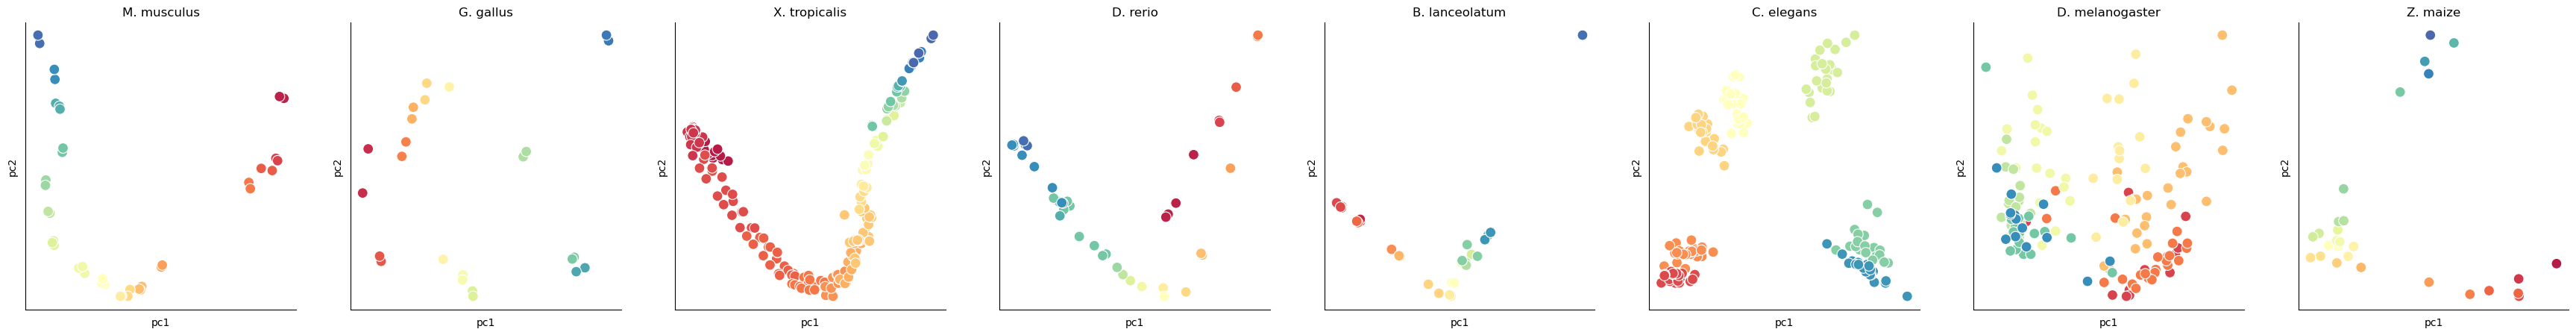

In [7]:
fig, axes = plt.subplots(1, len(assembly2species.keys()), figsize=(5.5*len(assembly2species),5))


def descriptive2stageidx(samplename, samples, assembly):
    stage = samples[(samples["assembly"] == assembly) & (samples["descriptive_name"] == samplename)]["stage"]
    return assembly2stages[assembly].index(stage.values[0])

for i, assembly in enumerate(assembly2species.keys()):
    df = dfs[assembly].copy()
    df.values[:] = scipy.stats.zscore(df, axis=1)
    df = df.dropna()

    pca = PCA(n_components=2)
    df_coding_PCs = pd.DataFrame(pca.fit_transform(df.transpose()))
    df_coding_PCs.columns = ["pc1", "pc2"]
    df_coding_PCs["sample"] = df.columns
    df_coding_PCs["stage"] = [descriptive2stageidx(samplename, samples, assembly) for samplename in df_coding_PCs["sample"]]
    palette = sns.color_palette("Spectral", len(assembly2stages[assembly])).as_hex()
    df_coding_PCs["color"] = [palette[x] for x in df_coding_PCs["stage"]]

    
    ax = sns.scatterplot(
        x="pc1", 
        y="pc2",
        data=df_coding_PCs,
        hue="stage",
        s=100,
        ax=axes[i],
        palette=palette,
        legend=False,
    ).set(title=assembly2species[assembly])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].spines[['right', 'top']].set_visible(False)
#     axes[i].axis('equal')


# variance over time

In [9]:
# bootstraps = 250
# bootstrap_df = []

# for species in ["C. elegans", "D. melanogaster", "D. rerio"]:
#     assembly = species2assembly[species]
#     stage2samples = {
#         stage: [x for x in dfs[assembly].columns if stage in x] for stage in assembly2stages[assembly]
#     }
#     df = dfs[assembly]
#     for stage in assembly2stages[assembly]:
#         pretty_stage_name = stage.replace("_", " ")
#         all_samples = samples[
#             (samples["assembly"] == assembly) &\
#             (samples["stage"] == stage)
#         ]["descriptive_name"].to_list()
#         all_samples = list(set(all_samples).intersection(df.columns))
#         for bootstrap in range(bootstraps):
#             sample1, sample2 = random.sample(all_samples, 2)
#             rho, pval = scipy.stats.spearmanr(df[sample1], df[sample2])
#             bootstrap_df.append([assembly2species[assembly], pretty_stage_name, rho])

# bootstrap_df = pd.DataFrame(bootstrap_df, columns=["assembly", "stage", "spearman"])
# # bootstrap_df

ValueError: Sample larger than population or is negative

In [ ]:
# # i = bootstrap_df.shape[0]
# bootstrap_df.loc[i+i] = ["D. melanogaster", "0 hpf", None]

In [ ]:
# fig, axes = plt.subplots(1, 3, figsize=(20,5), sharey=False)
# plt.xticks(rotation=45, ha='right')

# for i, species in enumerate(["C. elegans", "D. melanogaster", "D. rerio"]):
#     df = bootstrap_df[(bootstrap_df["assembly"] == species)]

#     palette = sns.color_palette("Spectral", df["stage"].nunique()).as_hex()

#     ax = sns.boxplot(
#         x="stage", 
#         y="spearman",
#         data=df,
#         ax=axes[i],
#         palette=palette,
#         showfliers=False
#     ).set(title=f"{species}: spearman correlation within stage")
#     axes[i].tick_params(axis='x', rotation=45)

# plt.savefig("/tmp/test.svg")


# cross species

In [8]:
descriptive2stage = {k: v for k, v in zip(samples["descriptive_name"], samples["stage"])}
dfs_stages = dict()
for assembly in assembly2species.keys():
    # take the average over stages
    df_molten = dfs[assembly].melt(ignore_index=False).reset_index()
    df_molten["stage"] = [descriptive2stage[x] for x in df_molten["variable"]]
    dfs_stages[assembly] = df_molten.groupby(["orthogroup", "gene", "stage"]).mean(numeric_only=True).reset_index().pivot(index=["orthogroup", "gene"], columns="stage")
    # make sure the columns are ordered as in the samples file
    dfs_stages[assembly].columns = [x for _, x in dfs_stages[assembly].columns]
    dfs_stages[assembly] = dfs_stages[assembly][list(dict.fromkeys(samples[samples["assembly"] == assembly]["stage"]))]

dfs_stages

{'GRCm38.p6':                            2cell     8cell    morula  blastocyst      E7.5  \
 orthogroup    gene                                                           
 N0.HOG0000000 Cyp17a1   1.624151  3.277531  4.401185    3.265228  3.457211   
               Cyp1a1    0.102920  0.115492  0.016412    0.075777  0.363606   
               Cyp1a2    0.109846  3.660910  1.431730    0.828674  0.023982   
               Cyp21a1   0.255673  0.045627  0.046778    0.025743  0.023631   
               Cyp2a12   0.335316  0.754793  0.598315    0.330999  0.027265   
 ...                          ...       ...       ...         ...       ...   
 N0.HOG0024792 Bpifa6    2.348959  0.029138  0.000000    0.094645  0.000000   
 N0.HOG0024793 Svs5      0.000000  0.000000  0.000000    0.000000  0.000000   
               Svs6      0.000000  0.000000  0.000000    0.000000  0.000000   
 N0.HOG0024794 Olfr1406  0.000000  0.000000  0.000000    0.000000  0.000000   
               Olfr1408  0.000000  0.00

In [16]:
# import matplotlib.patches as patches


# nrows = 6
# fig, axes = plt.subplots(nrows, len(assembly2species.keys()), figsize=(5.5*len(assembly2species),nrows*5))

# for i, assembly in enumerate(assembly2species.keys()):
#     df = dfs_stages[assembly].copy()

#     pred_gene_landscape = gene_landscape(df)

#     # keep only
#     df.index = df.index.droplevel(0)
#     df = df.loc[pred_gene_landscape.index.get_level_values(1)]

#     ys = df.mean(axis=1).rank()
#     print(ys.shape)
#     _ = axes[0, i].hist(pred_gene_landscape["late"], bins=40)
#     _ = axes[1, i].hist(pred_gene_landscape["mid-development"], bins=40)
#     _ = axes[2, i].scatter(pred_gene_landscape["late"], df.mean(axis=1))
#     _ = axes[3, i].scatter(pred_gene_landscape["mid-development"], ys)
#     im = axes[4, i].hist2d(pred_gene_landscape["late"], pred_gene_landscape["mid-development"], bins=40, range=[[-1, 1], [-1, 1]])
#     axes[4, i].set_xlim([-1, 1])
#     axes[4, i].set_ylim([-1, 1])
#     patch = patches.Circle((0, 0), radius=1, transform=axes[4, i].transData)
#     im[-1].set_clip_path(patch)
#     _ = axes[5, i].scatter(pred_gene_landscape["late"], pred_gene_landscape["mid-development"])

#     #     break


In [ ]:
# fig, axes = plt.subplots(1, len(assembly2species.keys()), figsize=(5.5*len(assembly2species),5))

# for i, assembly in enumerate(assembly2species.keys()):
#     df = dfs_stages[assembly].copy()
#     df = df.groupby(level=0).mean()

#     pred_gene_landscape = gene_landscape(df)
#     _ = axes[i].hist2d(pred_gene_landscape["late"], pred_gene_landscape["mid-development"], bins=40)

GRCm38.p6 GRCm38.p6
galGal6 GRCm38.p6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


galGal6 galGal6
UCB_Xtro_10.0 GRCm38.p6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


UCB_Xtro_10.0 galGal6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


UCB_Xtro_10.0 UCB_Xtro_10.0
GRCz11 GRCm38.p6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCz11 galGal6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCz11 UCB_Xtro_10.0


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCz11 GRCz11
BraLan3 GRCm38.p6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BraLan3 galGal6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BraLan3 UCB_Xtro_10.0


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BraLan3 GRCz11


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BraLan3 BraLan3
ce11 GRCm38.p6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ce11 galGal6
ce11 UCB_Xtro_10.0


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ce11 GRCz11
ce11 BraLan3


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ce11 ce11
BDGP6.32 GRCm38.p6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BDGP6.32 galGal6
BDGP6.32 UCB_Xtro_10.0


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BDGP6.32 GRCz11


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BDGP6.32 BraLan3


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BDGP6.32 ce11
BDGP6.32 BDGP6.32
Zm-B73-REFERENCE-NAM-5.0 GRCm38.p6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 galGal6


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 UCB_Xtro_10.0


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 GRCz11


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 BraLan3


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 ce11
Zm-B73-REFERENCE-NAM-5.0 BDGP6.32


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 Zm-B73-REFERENCE-NAM-5.0


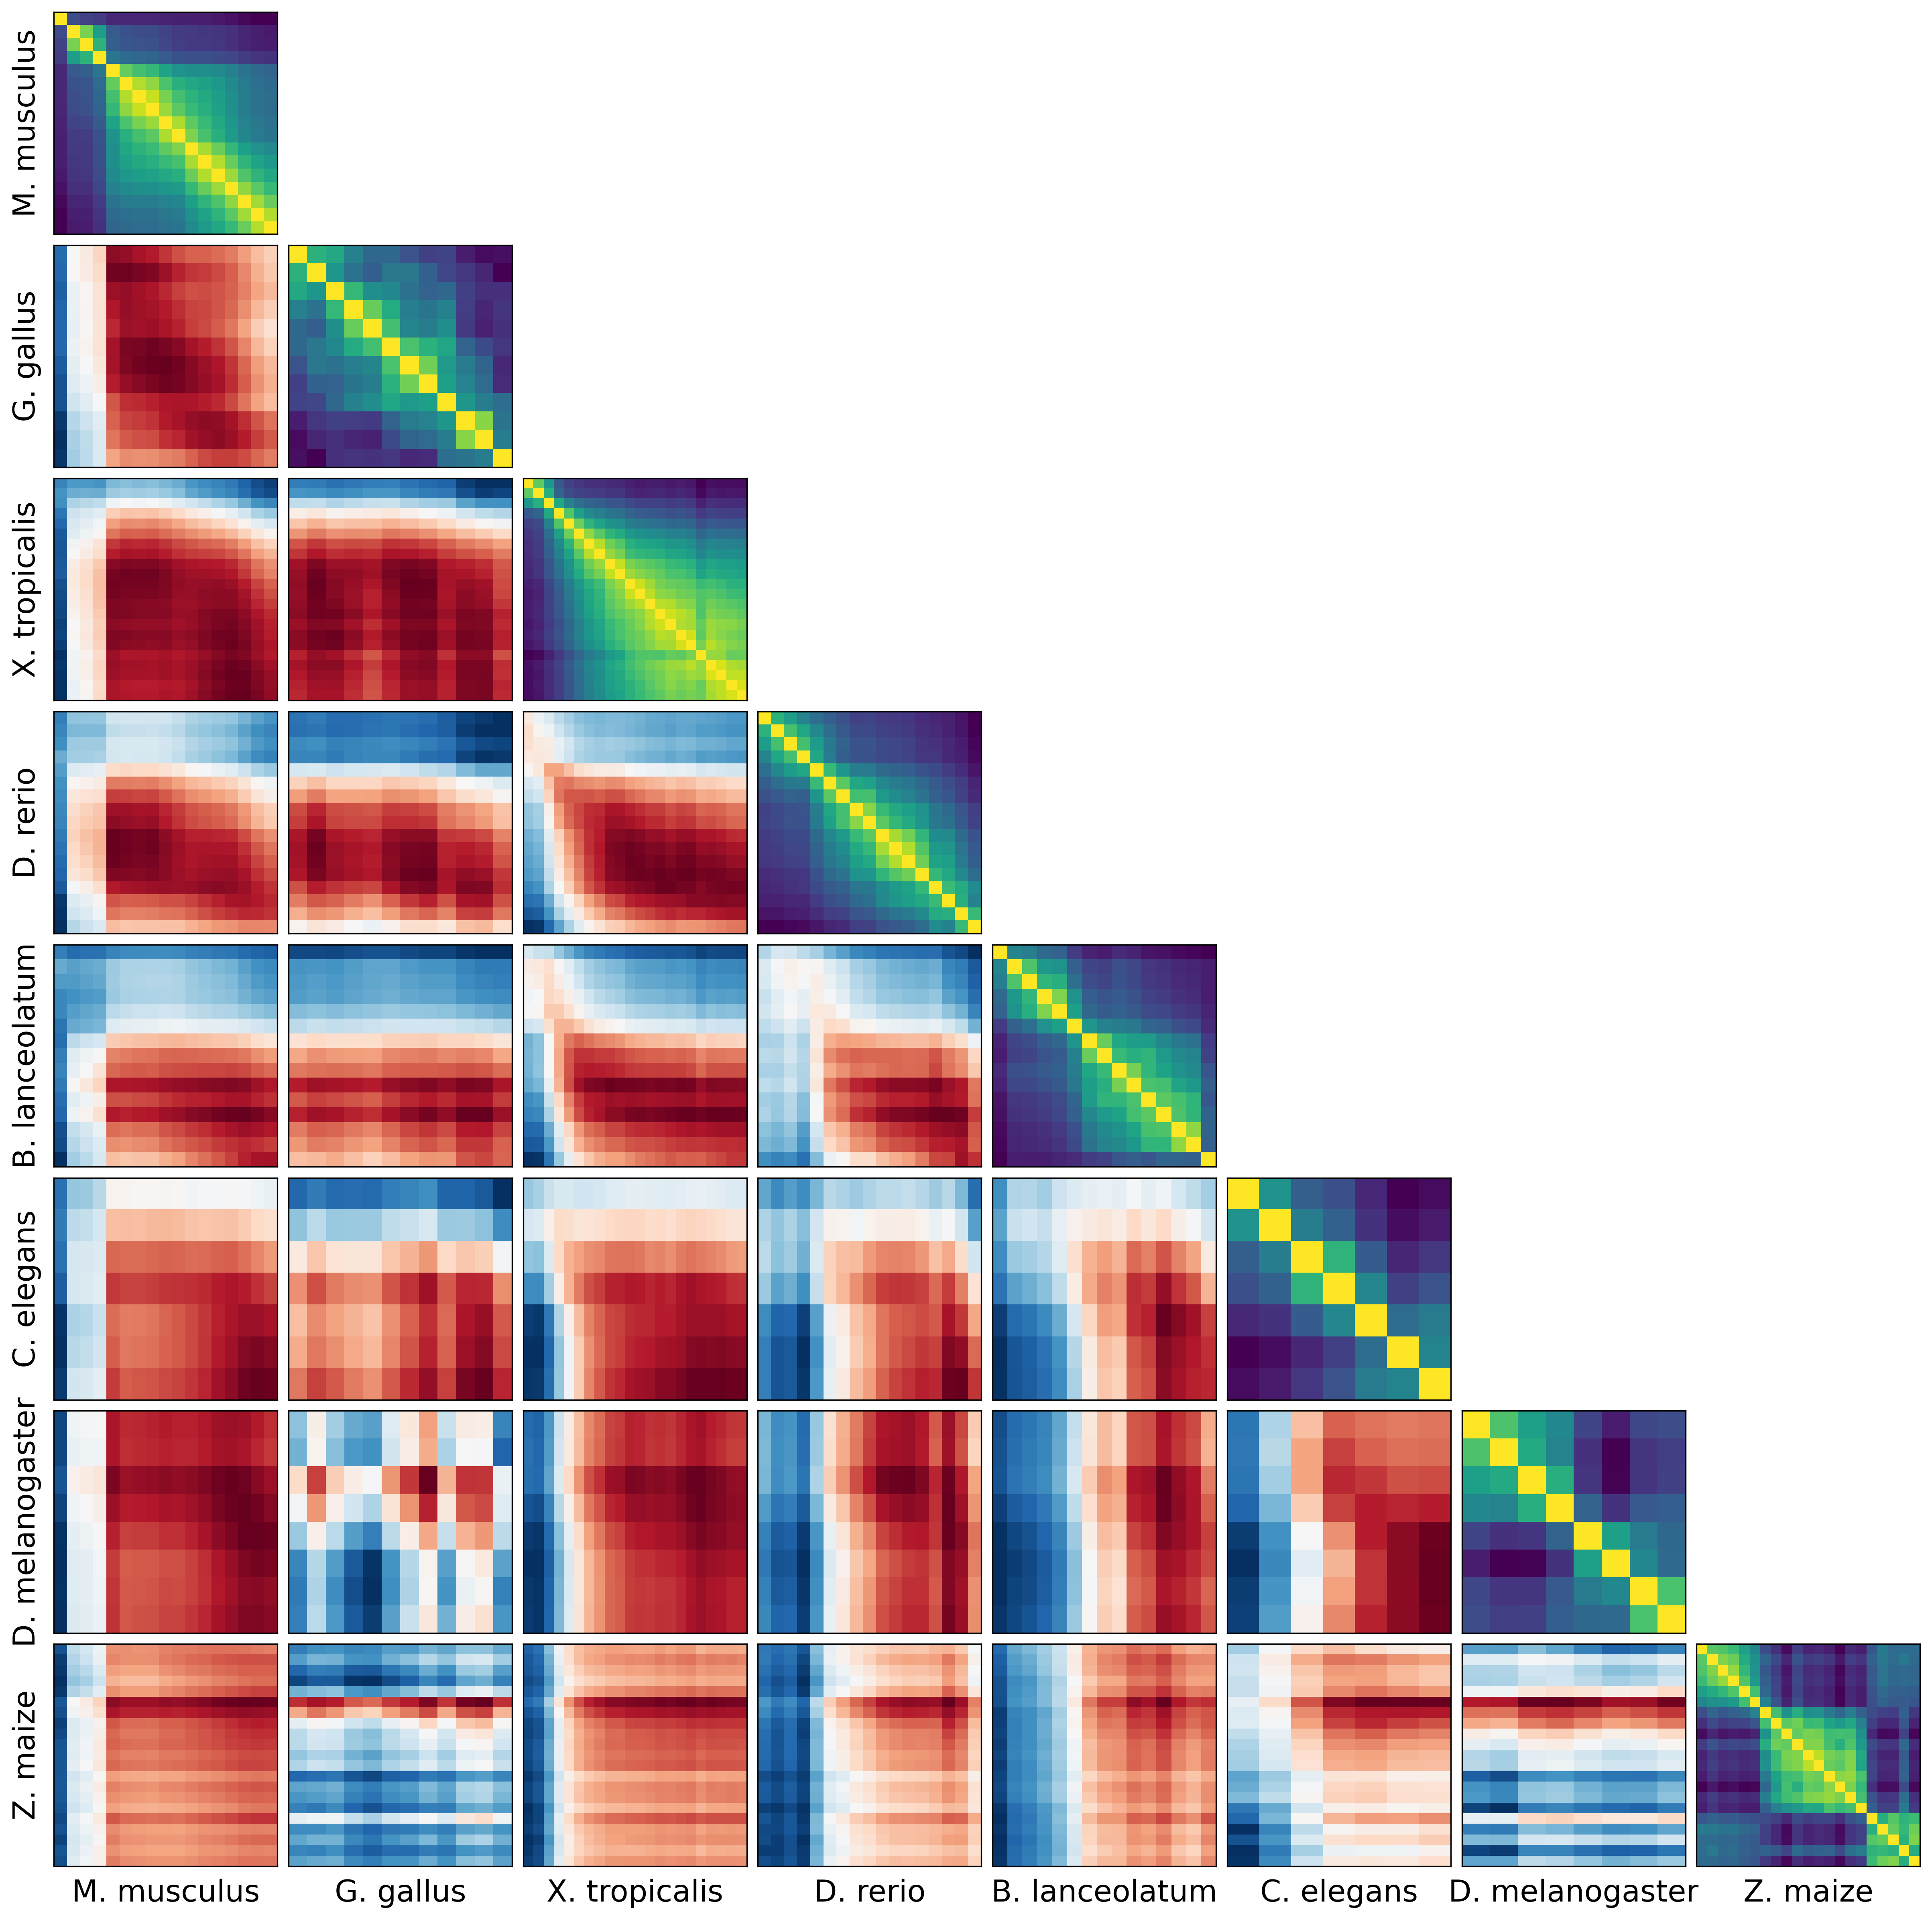

In [17]:
fig, axes = plt.subplots(figsize=(20, 20), nrows=len(assembly2species.keys()), ncols=len(assembly2species.keys()), dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)


for assembly_1_i, assembly_1 in enumerate(assembly2species.keys()):
    for assembly_2_i, assembly_2 in enumerate(assembly2species.keys()):
        ax = axes[assembly_1_i, assembly_2_i]

        if assembly_2_i > assembly_1_i: 
            ax.axis('off')
            continue
            
        print(assembly_1, assembly_2)

        df_X, df_Y = dfs_stages[assembly_1].copy(), dfs_stages[assembly_2].copy()
        
        if assembly_1 != assembly_2:
            orthos_X = df_X.index.get_level_values(0)
            orthos_Y = df_Y.index.get_level_values(0)

            # TODO choose:
            # Take mean of all orthogroups
            shared_orthogroups = list(set(orthos_X).intersection(set(orthos_Y)))

            # Take only one-to-one orthologs
            shared_orthogroups = list(set(orthos_X[~orthos_X.duplicated(keep=False)]).intersection(set(orthos_Y[~orthos_Y.duplicated(keep=False)])))

            # Take all orthogroups minus the one-to-one orthologs
            shared_orthogroups = list(set(orthos_X[orthos_X.duplicated(keep=False)]).intersection(set(orthos_Y[orthos_Y.duplicated(keep=False)])))

            # keep only the selected orthogroups
            df_X = df_X.loc[shared_orthogroups].groupby(level=0).mean()
            df_Y = df_Y.loc[shared_orthogroups].groupby(level=0).mean()
            
            df_X = qnorm.quantile_normalize(df_X)
            df_Y = qnorm.quantile_normalize(df_Y)
            
#             print(df_X.mean(axis=1))

#         df_X = qnorm.quantile_normalize(df_X)
#         df_Y = qnorm.quantile_normalize(df_Y)
#         df_X.values[:] = df_X.sample(frac=1)
#         df_Y.values[:] = df_Y.sample(frac=1)
        
#         df_X.values[:] = sklearn.preprocessing.minmax_scale(df_X, axis=1)
#         df_Y.values[:] = sklearn.preprocessing.minmax_scale(df_Y, axis=1)

#         df_X = df_X[df_X.columns[:len(df_X.columns) // 3]]
#         df_Y = df_Y[df_Y.columns[:len(df_Y.columns) // 3]]

#         df_X.values[:] = sklearn.preprocessing.minmax_scale(df_X, axis=1)
#         df_Y.values[:] = sklearn.preprocessing.minmax_scale(df_Y, axis=1)

        
#         corr_matrix = pairwise_spearman(df_X, df_Y)
        corr_matrix = pairwise_jensen_shannon(df_X, df_Y)
        
        if assembly_2_i == assembly_1_i: 
            ax.imshow(corr_matrix, origin='upper', cmap="viridis", interpolation='None', aspect="auto")#, vmin=0, vmax=1)
        else:
            ax.imshow(corr_matrix, origin='upper', cmap="RdBu_r", interpolation='None', aspect="auto")#, vmin=0, vmax=1)

        ax.set_xticks([])
        ax.set_yticks([])
        if assembly_2_i == 0:
            ax.set_ylabel(assembly2species[assembly_1], fontsize=18)
        if assembly_1_i == len(assembly2species.keys()) - 1:
            ax.set_xlabel(assembly2species[assembly_2], fontsize=18)


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCm38.p6 galGal6 2451


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCm38.p6 UCB_Xtro_10.0 2564


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCm38.p6 GRCz11 2626
GRCm38.p6 BraLan3 453
GRCm38.p6 ce11 533


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCm38.p6 BDGP6.32 571
GRCm38.p6 Zm-B73-REFERENCE-NAM-5.0 636


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


galGal6 GRCm38.p6 2451


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


galGal6 UCB_Xtro_10.0 2379


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


galGal6 GRCz11 2429
galGal6 BraLan3 430
galGal6 ce11 488
galGal6 BDGP6.32 516


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


galGal6 Zm-B73-REFERENCE-NAM-5.0 532


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


UCB_Xtro_10.0 GRCm38.p6 2564


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


UCB_Xtro_10.0 galGal6 2379
UCB_Xtro_10.0 GRCz11 2685
UCB_Xtro_10.0 BraLan3 472
UCB_Xtro_10.0 ce11 534


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


UCB_Xtro_10.0 BDGP6.32 566


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


UCB_Xtro_10.0 Zm-B73-REFERENCE-NAM-5.0 584


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCz11 GRCm38.p6 2626


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCz11 galGal6 2429
GRCz11 UCB_Xtro_10.0 2685
GRCz11 BraLan3 487
GRCz11 ce11 603


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCz11 BDGP6.32 646


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


GRCz11 Zm-B73-REFERENCE-NAM-5.0 746


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BraLan3 GRCm38.p6 453
BraLan3 galGal6 430
BraLan3 UCB_Xtro_10.0 472
BraLan3 GRCz11 487
BraLan3 ce11 224


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BraLan3 BDGP6.32 240
BraLan3 Zm-B73-REFERENCE-NAM-5.0 143
ce11 GRCm38.p6 533
ce11 galGal6 488
ce11 UCB_Xtro_10.0 534


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ce11 GRCz11 603
ce11 BraLan3 224
ce11 BDGP6.32 348


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


ce11 Zm-B73-REFERENCE-NAM-5.0 319
BDGP6.32 GRCm38.p6 571


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BDGP6.32 galGal6 516
BDGP6.32 UCB_Xtro_10.0 566
BDGP6.32 GRCz11 646


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BDGP6.32 BraLan3 240
BDGP6.32 ce11 348


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


BDGP6.32 Zm-B73-REFERENCE-NAM-5.0 336


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 GRCm38.p6 636


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 galGal6 532


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 UCB_Xtro_10.0 584


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 GRCz11 746
Zm-B73-REFERENCE-NAM-5.0 BraLan3 143
Zm-B73-REFERENCE-NAM-5.0 ce11 319


/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


Zm-B73-REFERENCE-NAM-5.0 BDGP6.32 336


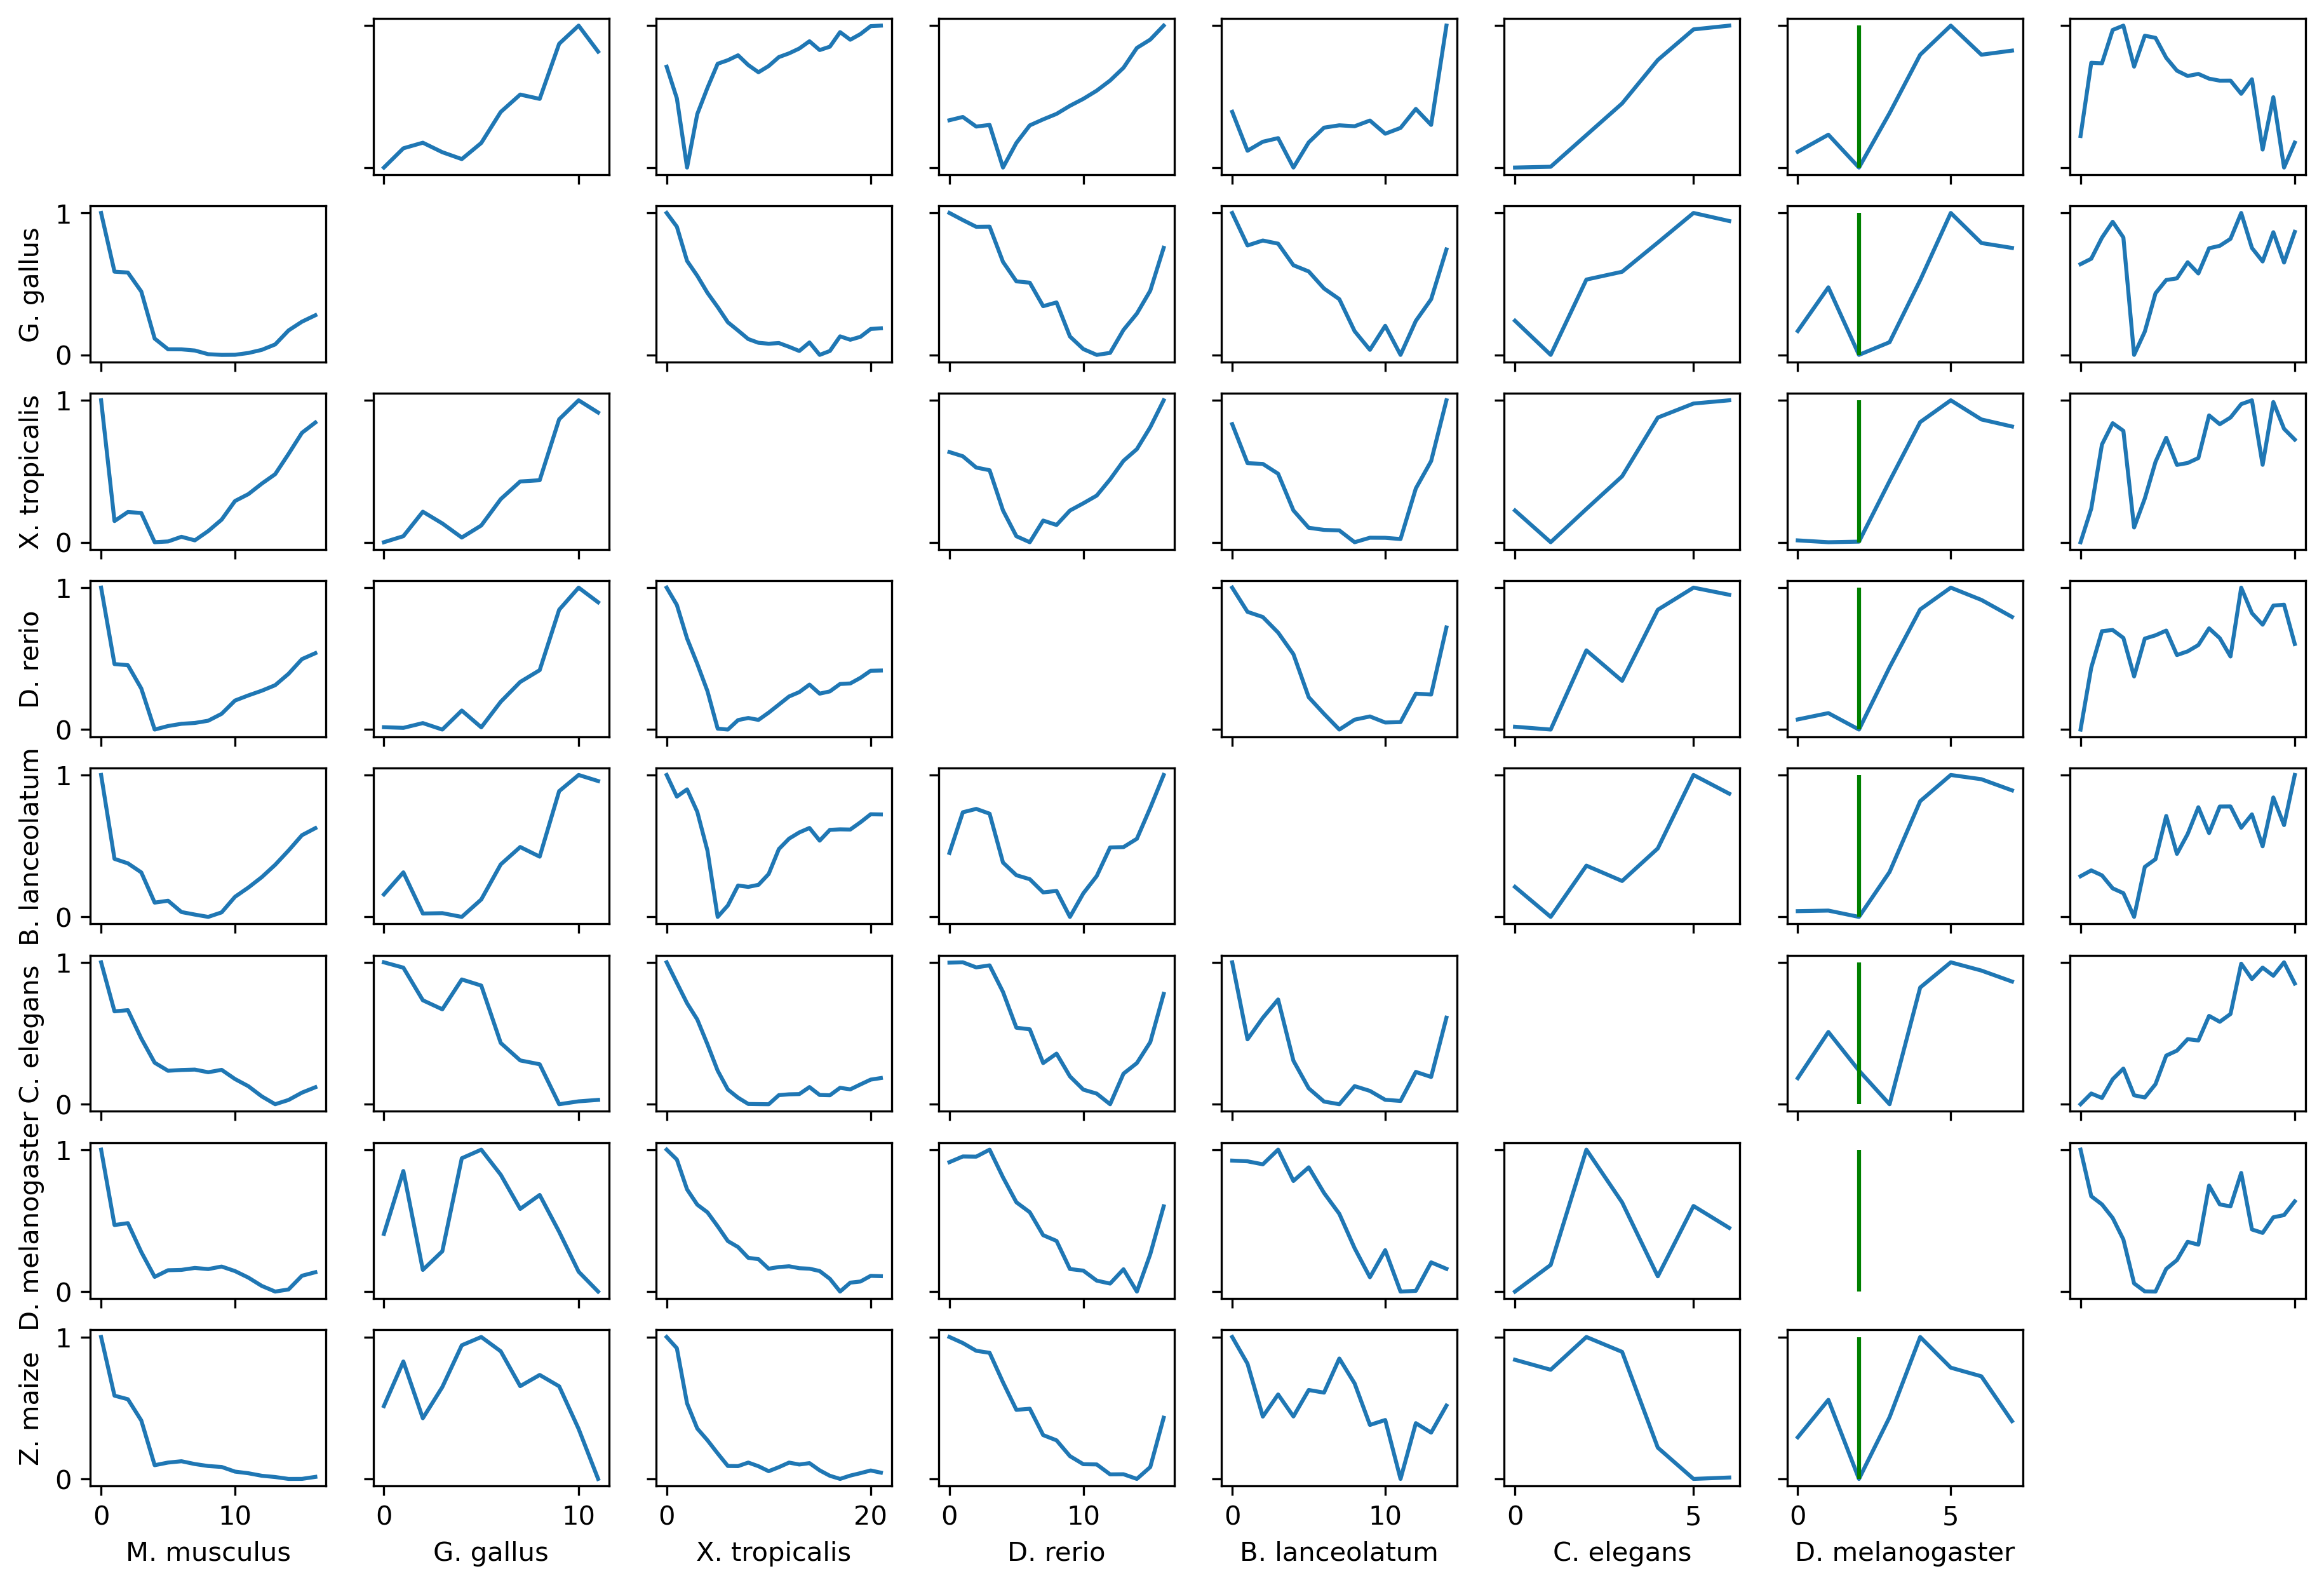

In [18]:
fig, axes = plt.subplots(figsize=(15, 10), nrows=len(assembly2species.keys()), ncols=len(assembly2species.keys()), dpi=300, sharey=True, sharex="col")
# plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)


for assembly_1_i, assembly_1 in enumerate(assembly2species.keys()):
    for assembly_2_i, assembly_2 in enumerate(assembly2species.keys()):
        ax = axes[assembly_2_i, assembly_1_i]

        if assembly_2_i == assembly_1_i: 
            ax.axis('off')
            continue
            
        df_X, df_Y = dfs_stages[assembly_1].copy(), dfs_stages[assembly_2].copy()
        
#         shared_orthogroups = list(set(df_X.index.get_level_values(0)).intersection(set(df_Y.index.get_level_values(0))))
#         vals = []
#         for i in range(1):
#             bootstrap_orthogroups = random.sample(shared_orthogroups, 200)
#             bootstrap_orthogroups = shared_orthogroups
#             df_X_bootstrap = df_X.loc[bootstrap_orthogroups].groupby(level=0).mean()
#             df_Y_bootstrap = df_Y.loc[bootstrap_orthogroups].groupby(level=0).mean()
            
        orthos_X = df_X.index.get_level_values(0)
        orthos_Y = df_Y.index.get_level_values(0)
        # TODO choose:
        # Take mean of all orthogroups
        shared_orthogroups = list(set(orthos_X).intersection(set(orthos_Y)))

        # Take only one-to-one orthologs
        shared_orthogroups = list(set(orthos_X[~orthos_X.duplicated(keep=False)]).intersection(set(orthos_Y[~orthos_Y.duplicated(keep=False)])))

        # Take all orthogroups minus the one-to-one orthologs
        shared_orthogroups = list(set(orthos_X[orthos_X.duplicated(keep=False)]).intersection(set(orthos_Y[orthos_Y.duplicated(keep=False)])))
        df_X_bootstrap = df_X.loc[shared_orthogroups].groupby(level=0).mean()
        df_Y_bootstrap = df_Y.loc[shared_orthogroups].groupby(level=0).mean()
        df_X_bootstrap = qnorm.quantile_normalize(df_X_bootstrap)
        df_Y_bootstrap = qnorm.quantile_normalize(df_Y_bootstrap)

        corr_matrix = -pairwise_jensen_shannon(df_X_bootstrap, df_Y_bootstrap)
        sns.lineplot(
            pd.DataFrame([sklearn.preprocessing.minmax_scale(np.max(corr_matrix, axis=1))]).melt(value_name="corr", var_name="tp"),
            x="tp", 
            y="corr", 
            ax=ax,
        )
        
#         corr_matrix = pairwise_spearman(df_X_bootstrap, df_Y_bootstrap)
#         sns.lineplot(
#             pd.DataFrame([sklearn.preprocessing.minmax_scale(np.max(corr_matrix, axis=1))]).melt(value_name="corr", var_name="tp"),
#             x="tp", 
#             y="corr", 
#             ax=ax,
#         )
        
#         corr_matrix = pairwise_pearson(df_X_bootstrap, df_Y_bootstrap)
#         sns.lineplot(
#             pd.DataFrame([sklearn.preprocessing.minmax_scale(np.max(corr_matrix, axis=1))]).melt(value_name="corr", var_name="tp"),
#             x="tp", 
#             y="corr", 
#             ax=ax,
#         )
        
        print(assembly_1, assembly_2, len(shared_orthogroups))





for label, ax in zip(assembly2species.values(), axes[:, 0]):
    ax.set(ylabel=label)

for label, ax in zip(assembly2species.values(), axes[-1, :]):
    ax.set(xlabel=label)

# for ax in axes[:, 1]:
#     ax.vlines([3, 4], ymin=0, ymax=1, colors="g")
    
for ax in axes[:, 6]:
    ax.vlines(2, ymin=0, ymax=1, colors="g")
    
# for ax in axes[:, 3]:
#     ax.vlines([11,12,13], ymin=0, ymax=1, colors="g")
#     ax.vlines([6], ymin=0, ymax=1, colors="r")

WIP below

In [17]:
mg = mygene.MyGeneInfo()


dfs

{'BraLan2':                        blastula_rep1  blastula_rep2  7hpf_rep1  7hpf_rep2  \
 N0.HOG0002485 BL00000       9.006864      10.473768  11.131918  11.321815   
 N0.HOG0001034 BL00001       0.314530       0.505632   1.582768   1.885674   
 NaN           BL00002     199.480507     208.011127  85.017797  81.173553   
 N0.HOG0000120 BL00003       0.000000       0.000000   0.168061   0.000000   
 N0.HOG0000339 BL00004       3.301539       2.508992   2.809257   3.364099   
 ...                              ...            ...        ...        ...   
 N0.HOG0000781 BL97479       8.252439       6.307818   7.616011   4.261596   
 NaN           BL97480      44.600949      49.672246  10.581812   9.588239   
 N0.HOG0016913 BL97481       1.508400       1.454923   0.490464   0.362937   
 N0.HOG0000735 BL97482       0.000000       0.000000   0.000000   0.662167   
 N0.HOG0014660 BL97483       0.000000       0.000000   0.328765   0.000000   
 
                         8hpf_rep1   8hpf_rep2  10h

In [ ]:
# TODO add **all** species (zebrafish & xenopus & ce11 & dm6)
# TODO prefer ENSG instead of gene name / alias
# mouse and human


# all_genes = [gene for genes in cur.execute(f"SELECT gene_id FROM genes WHERE assembly='human' OR assembly='mouse'").fetchall() for gene in genes]
# all_genes = mg.querymany(all_genes, scopes="ensembl.gene,symbol,alias", fields="symbol,go,alias", as_dataframe=True, returnall=True)["out"]
# all_genes


all_genes_index = set(all_genes.index)
all_genes_index_iloc = {gene: i for i, gene in enumerate(all_genes.index)}
all_genes_index_iloc
for orthogroup, *_ in set(cur.execute(f"""
    SELECT genes.orthogroup from 
    ORTHOGROUPS INNER JOIN genes ON ORTHOGROUPS.orthogroup=genes.orthogroup
    WHERE genes.assembly='human' OR genes.assembly='mouse'""").fetchall()):
#     print(orthogroup)
    genes = tuple({gene for genes in cur.execute(f"SELECT gene_id FROM genes WHERE (assembly='human' OR assembly='mouse') AND orthogroup='{orthogroup}'").fetchall() for gene in genes if gene is not None})
    good_genes = all_genes_index.intersection(genes)
    good_genes_idx = [all_genes_index_iloc[gene] for gene in good_genes]
    good_genes_idx = [x for x in good_genes_idx if x]
    
    go_terms = all_genes.iloc[good_genes_idx][["go.MF", "go.BP", "go.CC"]].stack().values
    if len(go_terms) == 0:
        continue
    go_terms = {x["id"] for x in go_terms[0]}

    hits = all_go_terms.intersection(go_terms)

    if hits:
        go_orthogroups.append(orthogroup)
        print(genes)
        print(go_terms)

    
#     orthos_checked.append(orthogroup)
#     genes_checked.append(good_genes)

# all_genes.loc[genes_checked, ["go.MF", "go.BP", "go.CC"]]
    
# for orthogroup, good_genes in zip(orthos_checked, genes_checked):
#     print(orthogroup)
#     go_terms = all_genes.loc[good_genes, ["go.MF", "go.BP", "go.CC"]]#.stack().values
#     if len(go_terms) == 0:
#         continue
#     go_terms = {x["id"] for x in go_terms[0]}

#     hits = all_go_terms.intersection(go_terms)

#     if hits:
#         go_orthogroups.append(orthogroup)
#         print(genes)
#         print(go_terms)


In [28]:
dfs

{'BraLan2':                        blastula_rep1  blastula_rep2  7hpf_rep1  7hpf_rep2  \
 orthogroup    gene                                                          
 N0.HOG0002485 BL00000       9.006864      10.473768  11.131918  11.321815   
 N0.HOG0001034 BL00001       0.314530       0.505632   1.582768   1.885674   
 NaN           BL00002     199.480507     208.011127  85.017797  81.173553   
 N0.HOG0000120 BL00003       0.000000       0.000000   0.168061   0.000000   
 N0.HOG0000339 BL00004       3.301539       2.508992   2.809257   3.364099   
 ...                              ...            ...        ...        ...   
 N0.HOG0000781 BL97479       8.252439       6.307818   7.616011   4.261596   
 NaN           BL97480      44.600949      49.672246  10.581812   9.588239   
 N0.HOG0016913 BL97481       1.508400       1.454923   0.490464   0.362937   
 N0.HOG0000735 BL97482       0.000000       0.000000   0.000000   0.662167   
 N0.HOG0014660 BL97483       0.000000       0.000000 

In [30]:
mg.querymany(["zyg-12"], scopes="ensembl.gene,symbol,alias", fields="symbol,go,alias", as_dataframe=True, returnall=True)["out"]

querying 1-1...done.
Finished.
1 input query terms found dup hits:
	[('zyg-12', 2)]


,_id,_score,symbol,go.BP,go.CC,go.MF,alias
query,,,,,,,
zyg-12,24105291,17.235743,zyg-12,"[{'evidence': 'IMP', 'gocategory': 'BP', 'id':...","[{'evidence': 'IEA', 'gocategory': 'CC', 'id':...","[{'category': 'MF', 'evidence': 'IPI', 'id': '...",NaN
zyg-12,105218057,16.133139,LOC105218057,NaN,NaN,NaN,zyg-12


In [56]:
all_genes = [x[1] for df in dfs_stages.values() for x in df.index]
all_genes = mg.querymany(all_genes, scopes="ensembl.gene,symbol,alias", fields="symbol,go,alias", as_dataframe=True, returnall=True)["out"]
all_genes

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

,_id,_score,symbol,go.BP,go.CC,go.MF,go.MF.category,go.MF.evidence,go.MF.id,go.MF.qualifier,...,go.BP.term,go.CC.evidence,go.CC.gocategory,go.CC.id,go.CC.qualifier,go.CC.term,alias,go.CC.pubmed,go.MF.pubmed,notfound
query,,,,,,,,,,,,,,,,,,,,,
BL00045,BL00045,16.580470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BL00317,BL00317,16.580496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BL00340,BL00340,16.580542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BL00510,BL00510,16.580465,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BL01246,BL01246,16.580550,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSXETG00000039818,116407982,16.580580,LOC116407982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSXETG00000018647,448362,16.060162,MGC89221,NaN,NaN,NaN,MF,IEA,GO:0003796,enables,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSXETG00000031036,100493330,16.580496,LOC100493330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
FLYBASE
HGNC

NameError: name 'FLYBASE' is not defined

In [366]:
# load data
df_xenopus = dfs_stages["UCB_Xtro_10.0"].copy()
df_zebrafish = dfs_stages["GRCz11"].copy()
df_zebrafish_se = pd.read_table(f"../data_new/GRCz11-TPM_singleembryo.tsv.gz", index_col=0)
df_zebrafish_se

# get only orthogroups
orthos_xenopus = df_xenopus.index.get_level_values(0)
orthos_zebrafish = df_zebrafish.index.get_level_values(0)
shared_orthogroups = list(set(orthos_xenopus[~orthos_xenopus.duplicated(keep=False)]).intersection(set(orthos_zebrafish[~orthos_zebrafish.duplicated(keep=False)])))
# shared_orthogroups = list(set(orthos_xenopus[orthos_xenopus.duplicated(keep=False)]).intersection(set(orthos_zebrafish[orthos_zebrafish.duplicated(keep=False)])))
df_xenopus = df_xenopus.loc[shared_orthogroups]
df_zebrafish = df_zebrafish.loc[shared_orthogroups]

# subset single embryo on orthogroups
df_zebrafish_se = df_zebrafish_se.loc[df_zebrafish.index.get_level_values(1)]
df_zebrafish_se.index = df_zebrafish.index.get_level_values(0)

# keep only orthogroup identifier
df_xenopus = df_xenopus.loc[shared_orthogroups].groupby(level=0).mean()
df_zebrafish = df_zebrafish.loc[shared_orthogroups].groupby(level=0).mean()
df_zebrafish_se = df_zebrafish_se.loc[df_zebrafish.index]

# quantile normalize
df_xenopus = qnorm.quantile_normalize(df_xenopus)
df_zebrafish = qnorm.quantile_normalize(df_zebrafish)

In [367]:
df_zebrafish_se

,1-cell_rep1,1-cell_rep2,1-cell_rep3,1-cell_rep4,1-cell_rep5,1-cell_rep6,1-cell_rep7,1-cell_rep8,1-cell_rep9,1-cell_rep10,...,Day-5_rep5,Day-5_rep7,Day-5_rep9,Day-5_rep11,Day-5_rep13,Day-5_rep15,Day-5_rep17,Day-5_rep19,Day-5_rep21,Day-5_rep23
orthogroup,,,,,,,,,,,,,,,,,,,,,
N0.HOG0000101,1.817105,1.997768,1.609723,1.285500,2.551246,1.764183,2.776308,2.310847,3.087172,1.440732,...,0.000000,0.171070,0.000000,0.148184,0.142349,0.000000,0.188822,0.000000,0.000000,0.000000
N0.HOG0000146,55.792141,59.285217,53.566669,61.599171,57.676764,62.762249,64.366862,54.151185,65.253472,60.240865,...,11.124432,19.786895,8.144086,10.907096,11.675058,7.123892,15.883778,9.944061,5.241907,12.238729
N0.HOG0000205,1.997491,1.220049,2.602238,4.289806,2.921365,1.414084,4.838401,3.326514,3.307359,3.260672,...,16.267880,21.626058,20.905068,20.769011,15.648006,10.688575,25.945880,10.060462,18.103711,15.460291
N0.HOG0000218,11.321606,9.322624,7.997377,9.153602,9.419688,7.531466,9.281848,7.922656,14.489530,10.443351,...,1.395063,1.658015,1.148976,2.256883,1.182554,1.563405,2.352945,1.478344,0.493022,2.148723
N0.HOG0000249,0.390690,0.000000,0.203589,0.000000,0.228556,0.000000,0.291183,0.000000,0.225004,0.000000,...,0.000000,1.103438,0.892107,0.000000,0.000000,0.000000,0.405981,0.327955,0.000000,0.417087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N0.HOG0024951,7.655396,2.877444,3.068644,2.678125,2.411478,5.479040,1.755569,2.496286,5.595862,5.767637,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
N0.HOG0024954,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,70.998532,79.126354,70.969034,62.828792,48.695379,50.172598,138.284141,49.239300,66.481066,43.928655
N0.HOG0024971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.204758,0.278117,1.124261,0.722728,0.231423,0.407940,0.306977,0.743937,0.868351,0.946126


In [368]:
df_zebrafish

,Eggs,2-4cells,2hpf,1Kcells,Dome,Shield,8hpf,Bud,12hpf,16hpf,20hpf,26hpf,28hpf,48hpf,72hpf,120hpf,7dpf
orthogroup,,,,,,,,,,,,,,,,,
N0.HOG0000101,22.828324,41.778631,50.465544,40.940440,35.534878,12.159136,8.619821,10.002444,9.449723,7.816487,5.932361,5.726529,6.002031,5.077501,2.931899,2.577397,4.128474
N0.HOG0000146,151.051252,30.591169,100.832313,2586.652656,394.996992,131.331020,113.874988,146.506213,122.803896,226.619397,246.471218,226.619397,222.679238,339.390392,267.572179,227.741237,118.939103
N0.HOG0000205,6.351853,11.876697,16.510674,10.422738,9.515545,4.275556,6.423507,9.721591,15.214011,26.069258,38.678967,66.054042,65.379478,80.828121,140.634466,63.024204,33.525071
N0.HOG0000218,38.616111,27.886037,32.157755,22.780489,25.100699,21.466780,32.678694,18.879154,25.913473,15.957975,14.499134,13.783502,10.585448,4.441846,5.938755,2.315099,0.567062
N0.HOG0000249,0.216271,0.288060,0.623793,0.792954,0.212827,0.862857,0.835787,1.279958,1.385027,1.856463,1.076358,0.781823,0.539051,0.321560,0.136662,0.155866,0.046021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N0.HOG0024951,7.921216,23.320108,9.793177,9.681150,3.480610,2.655163,1.217002,0.496952,0.276944,0.088749,0.027410,0.041123,0.036619,0.065162,0.003449,0.051039,0.062954
N0.HOG0024954,0.061303,0.081395,0.077059,0.053680,0.035811,0.164447,0.223970,0.196518,0.037136,0.098753,0.174573,0.510119,3.026889,226.005595,702.563440,651.772383,563.526619
N0.HOG0024971,2.134677,1.894618,1.748406,1.398083,1.145466,1.414466,1.496489,1.259705,2.271585,1.422954,1.037859,0.934030,0.230399,0.341503,0.389230,1.824427,41.609035


In [369]:
df_xenopus

,0-2hpf,3-5hpf,6-8hpf,9-11hpf,12-14hpf,15-17hpf,18-20hpf,21-23hpf,24-26hpf,27-29hpf,...,36-38hpf,39-41hpf,42-44hpf,45-47hpf,48-50hpf,51-53hpf,54-56hpf,57-59hpf,60-62hpf,63-66hpf
orthogroup,,,,,,,,,,,,,,,,,,,,,
N0.HOG0000101,4.817913,5.104328,5.155512,3.913937,3.240134,2.817622,2.528091,2.612989,2.769209,2.869191,...,3.437275,2.636048,3.077283,2.678494,2.645447,4.221101,2.696396,3.166736,2.431424,2.510106
N0.HOG0000146,49.058618,91.664147,64.484988,78.213224,116.954429,247.111105,388.985192,396.305008,424.258635,411.191055,...,452.309238,407.402865,400.370164,411.191055,375.956482,276.235434,315.646405,331.161594,331.161594,304.671862
N0.HOG0000205,5.759038,5.032205,3.688484,2.422323,1.561212,1.369825,1.664605,2.067601,4.401180,3.569334,...,6.568735,6.688039,8.513749,8.361201,9.234582,17.168405,13.633468,16.192251,16.938815,19.172976
N0.HOG0000218,85.446496,62.577415,75.082339,70.150264,40.205976,23.419553,23.853529,26.213974,30.243057,26.558294,...,29.492121,27.151283,26.200249,27.328253,29.648791,33.756059,29.027558,25.627906,23.466945,22.368758
N0.HOG0000249,1.150460,0.879804,0.258990,0.073638,0.047470,0.008489,0.007223,0.006921,0.000180,0.001628,...,0.001319,0.005896,0.001030,0.000500,0.000319,0.014243,0.019402,0.000319,0.000242,0.000070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N0.HOG0024951,90.432114,15.459077,15.860148,8.211625,3.928479,2.250312,1.228659,0.977161,0.714920,0.726321,...,0.367816,0.190534,0.235775,0.239574,0.104343,0.112675,0.060802,0.103073,0.066534,0.069096
N0.HOG0024954,0.184200,0.258990,0.580779,0.397699,0.252429,0.053094,0.052161,0.087554,0.172680,0.397699,...,0.721378,0.596057,0.680064,0.642311,0.757386,1.456090,0.973754,1.138712,1.150460,1.282446
N0.HOG0024971,5.119624,6.498206,8.095123,12.085696,6.824919,4.304268,3.834870,4.687657,8.677365,11.436820,...,14.148725,12.473473,12.893046,11.835767,11.742807,22.594084,13.206758,11.742807,12.338563,13.484611


In [370]:
orthoggroup = "N0.HOG0000101"
orthogroups_table.loc[orthoggroup, ["UCB_Xtro_10.0.pep", "GRCz11.pep"]]

UCB_Xtro_10.0.pep    abcc10|ENSXETG00000010586
GRCz11.pep           abcc10|ENSDARG00000077988
Name: N0.HOG0000101, dtype: object

In [418]:
corrs = pairwise_jensen_shannon(df_xenopus, df_zebrafish)
corrs

/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


array([[0.52984665, 0.52101215, 0.52522984, 0.5465549 , 0.56380887,
        0.60078545, 0.6116682 , 0.63425714, 0.63675363, 0.64809437,
        0.65323407, 0.65641323, 0.65884339, 0.66880581, 0.68912314,
        0.7029223 , 0.72508004],
       [0.559667  , 0.54916936, 0.53581988, 0.5336907 , 0.54680742,
        0.59260636, 0.60239867, 0.62567701, 0.62991336, 0.64318692,
        0.6482913 , 0.65197364, 0.65442543, 0.66322436, 0.68878693,
        0.70019347, 0.72222415],
       [0.58275556, 0.57283624, 0.53875777, 0.53546632, 0.49095941,
        0.52498358, 0.5319105 , 0.56209964, 0.56777611, 0.58490504,
        0.59153892, 0.59769757, 0.60314379, 0.61243384, 0.64339714,
        0.65540197, 0.68279288],
       [0.60401573, 0.60083574, 0.5705654 , 0.57083388, 0.48236809,
        0.46006235, 0.45089455, 0.47345994, 0.47802812, 0.49746032,
        0.5056644 , 0.51448578, 0.52239029, 0.53305041, 0.56628071,
        0.58096498, 0.61484647],
       [0.61072791, 0.6089623 , 0.58355211, 0.589830

([<matplotlib.axis.XTick at 0x7f20afe52ce0>,
 [Text(0, 0, 'Eggs'),
  Text(1, 0, '2-4cells'),
  Text(2, 0, '2hpf'),
  Text(3, 0, '1Kcells'),
  Text(4, 0, 'Dome'),
  Text(5, 0, 'Shield'),
  Text(6, 0, '8hpf'),
  Text(7, 0, 'Bud'),
  Text(8, 0, '12hpf'),
  Text(9, 0, '16hpf'),
  Text(10, 0, '20hpf'),
  Text(11, 0, '26hpf'),
  Text(12, 0, '28hpf'),
  Text(13, 0, '48hpf'),
  Text(14, 0, '72hpf'),
  Text(15, 0, '120hpf'),
  Text(16, 0, '7dpf')])

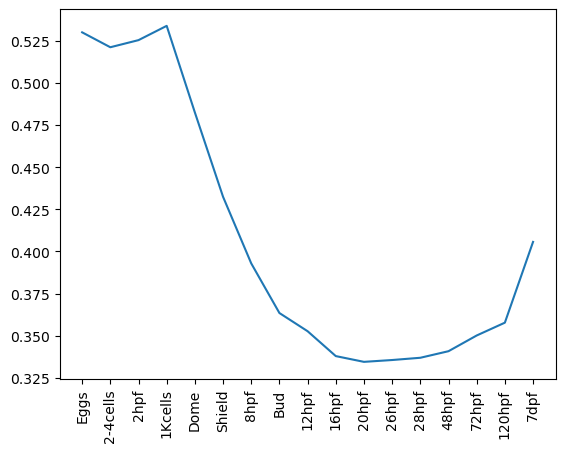

In [422]:
plt.plot(corrs.min(axis=0))
plt.xticks(range(len(df_zebrafish.columns)), df_zebrafish.columns, rotation='vertical')

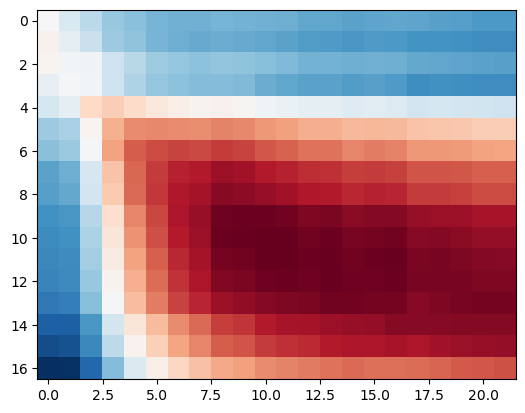

In [420]:
plt.imshow(-corrs.T, cmap="RdBu_r")

In [460]:
n_reps = 10

df_zebrafish_se
stages = ["1-cell", "2-cell", "128-cell", "1k-cell", "Dome", "50pc-epiboly", "Shield", "75pc-epiboly", "1-4-somites", "14-19-somites", "20-25-somites", "Prim-5", "Prim-15", "Prim-25", "Long-pec", "Protruding-mouth", "Day-4", "Day-5"]
stages

reps_per_stage = {}
for stage in stages:
    reps_per_stage[stage] = [col for col in df_zebrafish_se.columns if stage in col]
    
nr_reps = 1
table = []
for stage in stages:
    df = pd.DataFrame(df_zebrafish_se[random.choices(reps_per_stage[stage], k=nr_reps)].mean(axis=1))
    df.columns = [stage]
    table.append(df)

df_zebrafish_se_mean = pd.concat(table, axis=1)
df_zebrafish_se_mean = qnorm.quantile_normalize(df_zebrafish_se_mean, target=df_zebrafish["Eggs"])

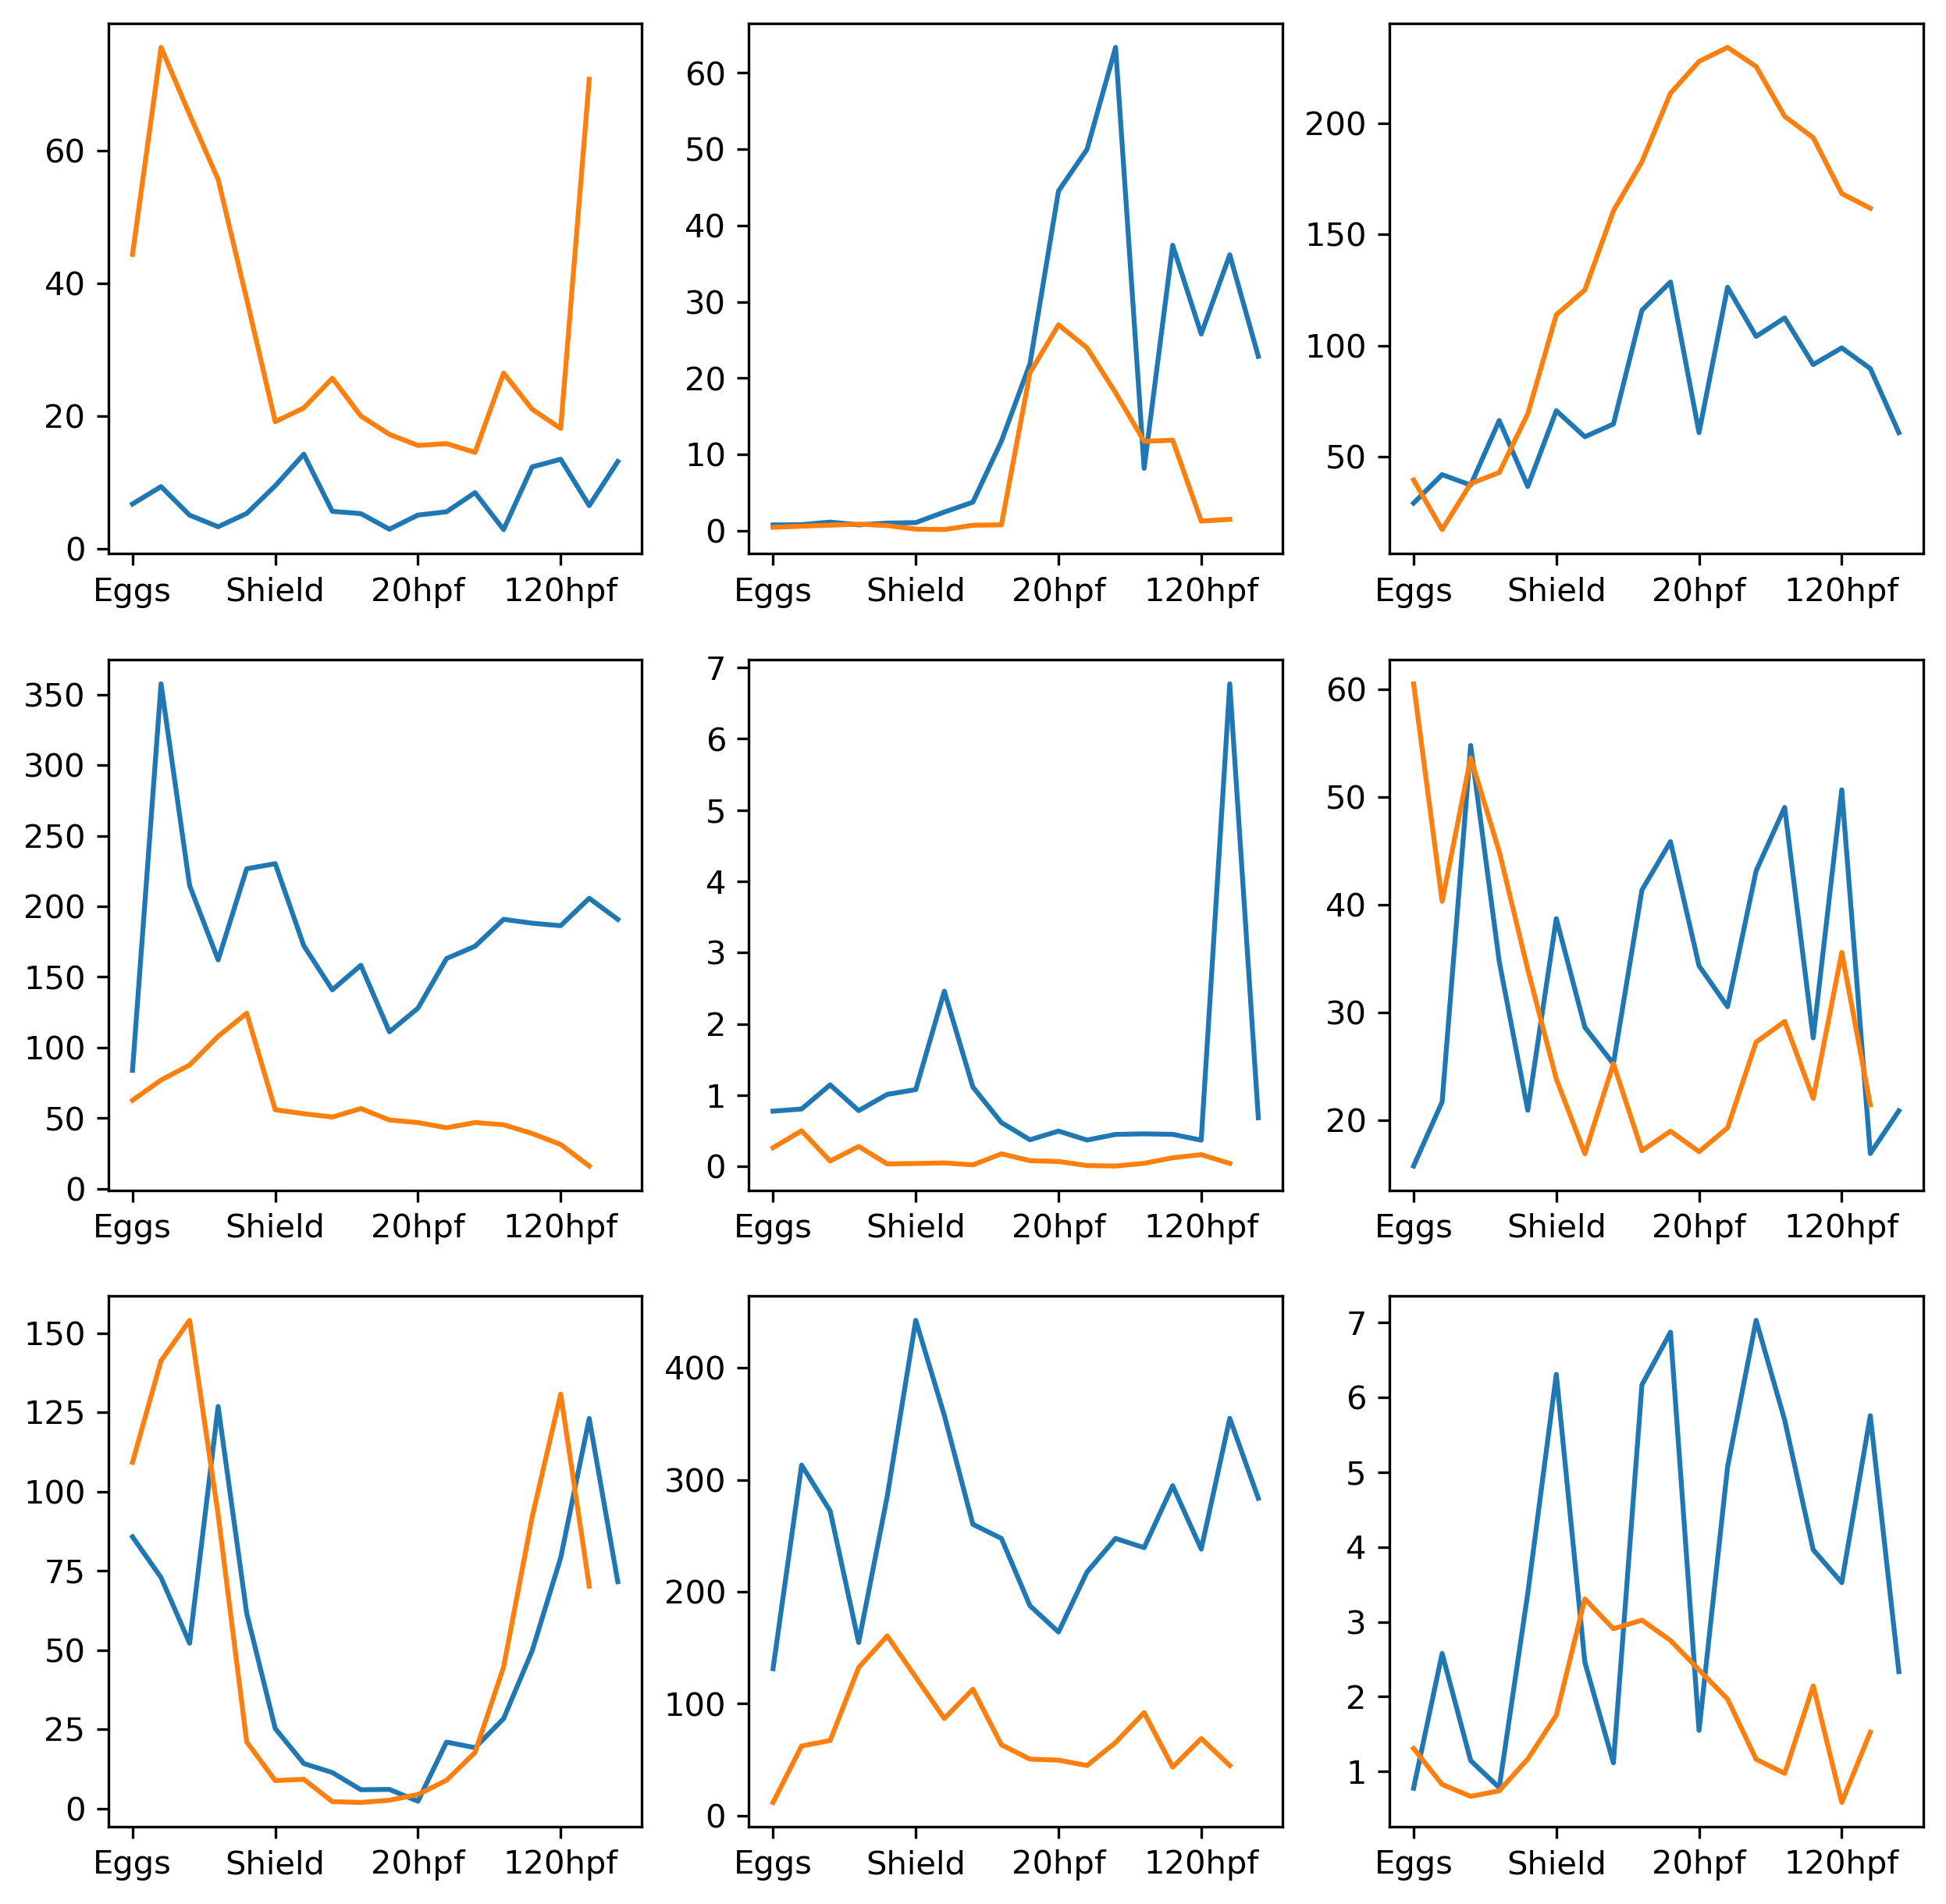

In [461]:
fig, axes = plt.subplots(figsize=(10, 10), nrows=3, ncols=3, dpi=300)

for i in range(3):
    for j in range(3):
        og = random.choice(df_zebrafish_se_mean.index)
        # og = "N0.HOG0024951"
        df_zebrafish_se_mean.loc[og].plot(ax=axes[i, j])
        df_zebrafish.loc[og].plot(ax=axes[i, j])

/home/sande/miniconda3/envs/phylotypic_hourglass/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


([<matplotlib.axis.XTick at 0x7f20e446aa10>,
 [Text(0, 0, '1-cell'),
  Text(1, 0, '2-cell'),
  Text(2, 0, '128-cell'),
  Text(3, 0, '1k-cell'),
  Text(4, 0, 'Dome'),
  Text(5, 0, '50pc-epiboly'),
  Text(6, 0, 'Shield'),
  Text(7, 0, '75pc-epiboly'),
  Text(8, 0, '1-4-somites'),
  Text(9, 0, '14-19-somites'),
  Text(10, 0, '20-25-somites'),
  Text(11, 0, 'Prim-5'),
  Text(12, 0, 'Prim-15'),
  Text(13, 0, 'Prim-25'),
  Text(14, 0, 'Long-pec'),
  Text(15, 0, 'Protruding-mouth'),
  Text(16, 0, 'Day-4'),
  Text(17, 0, 'Day-5')])

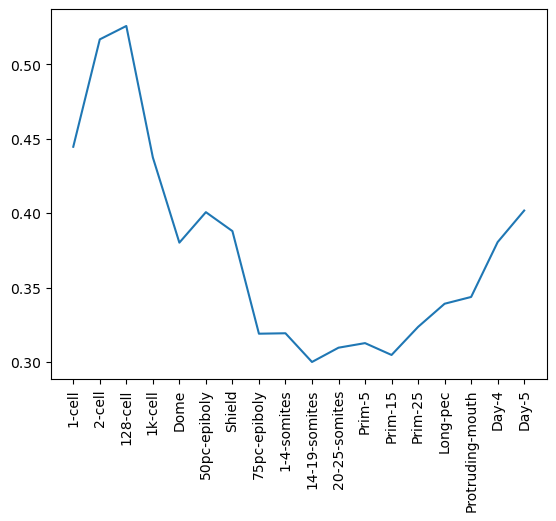

In [470]:
corrs = pairwise_jensen_shannon(df_zebrafish_se_mean, df_zebrafish)
plt.plot(corrs.min(axis=1))
plt.xticks(range(len(df_zebrafish_se_mean.columns)), df_zebrafish_se_mean.columns, rotation='vertical')

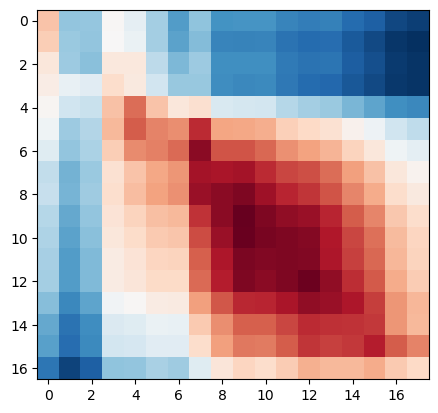

In [472]:
plt.imshow(-corrs.T, cmap="RdBu_r")

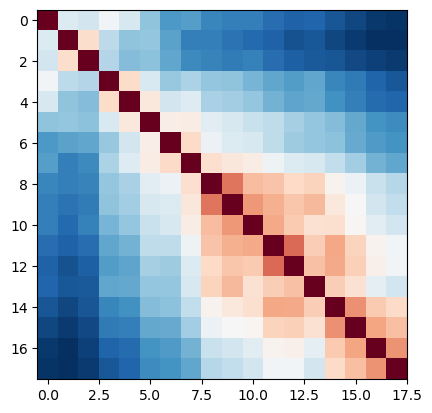

In [474]:
corrs = pairwise_jensen_shannon(df_zebrafish_se_mean, df_zebrafish_se_mean)
plt.imshow(-corrs.T, cmap="RdBu_r")